In [1]:
# !pip install langchain_community

In [2]:
from langchain_community.llms import Ollama

In [3]:
llm = Ollama(model="llama3.1")
llm.invoke("The Country Where Guinness is from...")

"You're thinking of Ireland!\n\nGuinness, the famous stout beer, has its origins in Dublin, Ireland. It was first brewed by Arthur Guinness at the St. James's Gate Brewery in 1759. The company that still produces Guinness today, Diageo, is headquartered in London, but the iconic brewery where it all began remains in Dublin.\n\nSo, to answer your question: yes, Guinness is from Ireland!"

In [4]:
# Read the Transaction Data 

import pandas as pd
df = pd.read_csv("/Users/vinayakpawar/Desktop/Work/Projects/Full_Stack_AI_Projects/Rebuild/FinLLM/Data_Set/bank_transactions.csv")
df.head()

,Date,Name,Expense,Amount
0,2023-04-26,Salary Deposit,Income,592.04
1,2024-04-05,Salary Deposit,Income,397.03
2,2023-07-23,Salary Deposit,Income,159.08
3,2024-10-30,Water Utility,Expense,391.51
4,2023-05-24,Salary Deposit,Income,527.63


In [5]:
# Get unique transaction in the Name/Description column

unique_transactions = df["Name"].unique()
len(unique_transactions)

26

In [6]:
unique_transactions[1:26]

array(['Water Utility', 'Spotify', 'Kroger', 'Misc Income',
       'Gym Membership', 'Target', 'Netflix', 'Apple Store', 'Uber',
       'Starbucks', 'Home Depot', 'Internet Provider', 'Walgreens',
       'Costco', 'Amazon', 'Phone Company', 'Best Buy',
       'Electric Company', 'Walmart', 'CVS Pharmacy', 'Rent Payment',
       "McDonald's", 'Car Insurance', 'Health Insurance', 'Shell Gas'],
      dtype=object)

### To get Most Optimal Tokenized Response we will feed only 30 unique transactions at a time.

In [7]:
# response = llm.invoke("Can you add an appropriate category next to each of the following expenses. Respond with a list of categories separated by commas. For example, Spotify - \
# Entertainment, Water Utility - Waterbill, Kroger - Shopping, Misc Income - Income, Gym Membership - Fitness, Target - Shopping, Netflix - Entertainment, Apple Store - Shopping, Uber - Taxi, Starbucks - Coffee, Home Depot - Shopping, Internet Provide - Internet Bill, Walgreens - Shopping, Costco - Shopping, Amazon - Shopping, Phone Company - Phonebill, Best Buy - Electronic shopping, Electric Company - ElectricBill, Walmart - Shopping, CVS Pharmacy - Pharmaceutical Shopping, Rent Payment - HouseRent, McDonald's - Takeout, Car Insurance - CarBill, Health Insurance - HealthBill, Shell Gas - Fuel etc.: \
# "+",".join(unique_transactions[1:30]))

In [8]:
# Assuming 'unique_transactions' is a list of unique transaction names you've extracted before this point

# Define transaction names explicitly from the unique transactions
transaction_names = ",".join(unique_transactions[1:30])  # Adjust the range as needed

# Now invoke the LLM with a defined prompt
response = llm.invoke(
    "Please categorize the following transactions based on common expense categories. Use categories like 'Groceries', 'Utilities', 'Transportation', 'Entertainment', etc.: " + transaction_names
)

# Process the response further as needed
print(response)


Here are the categorized transactions:

**Groceries:**

1. Kroger
2. Target
3. Costco
4. Walmart
5. CVS Pharmacy

**Entertainment:**

1. Spotify
2. Netflix
3. Apple Store (assuming a purchase of music or an app)
4. Uber (ride-sharing service for entertainment purposes)
5. McDonald's
6. Starbucks

**Utilities:**

1. Water Utility
2. Electric Company
3. Phone Company
4. Internet Provider

**Transportation:**

1. Shell Gas

**Health and Wellness:**

1. Gym Membership

**Shopping:**

1. Home Depot
2. Best Buy
3. Amazon (general shopping category)

**Income:**

1. Misc Income

**Rent/Insurance:**

1. Rent Payment
2. Car Insurance
3. Health Insurance


In [9]:
import pandas as pd

# Initialize an empty DataFrame to hold all categories
categories_df_all = pd.DataFrame(columns=['Transaction', 'Category'])

# Define a batch size for processing
batch_size = 30

# Loop through the list of unique transactions in batches
for start in range(0, len(unique_transactions), batch_size):
    transaction_names = unique_transactions[start:start + batch_size]
    transaction_names = ",".join(transaction_names)
    
    # Invoke the LLM for categorization
    response = llm.invoke(
        "Please categorize the following transactions based on common expense categories. Use categories like 'Groceries', 'Utilities', 'Transportation', 'Entertainment', etc.: " + transaction_names
    )
    
    # Debug: Print the raw response from the LLM
    print("LLM Response:")
    print(response)
    
    # Process the response
    response_lines = response.split('\n')
    
    current_category = None
    transaction_category_pairs = []
    
    for line in response_lines:
        line = line.strip()
        
        if line.startswith("**") and line.endswith("**"):  # Detect category headings
            current_category = line.strip('*').strip()
        elif line.startswith("*"):  # Detect transactions with bullet points
            transaction = line.lstrip("* ").strip()  # Strip the bullet point and any leading whitespace
            if current_category and transaction:  # Ensure category and transaction are valid
                transaction_category_pairs.append([transaction, current_category])
        elif line == '':  # Skip empty lines
            continue
        else:
            # Handle unexpected line formats, for debugging purposes
            print("Unexpected line format:", line)
    
    # Create a DataFrame from the response
    categories_df = pd.DataFrame(transaction_category_pairs, columns=['Transaction', 'Category'])
    
    # Concatenate the results to categories_df_all
    categories_df_all = pd.concat([categories_df_all, categories_df], ignore_index=True)

# Display the accumulated categories DataFrame
print(categories_df_all.head())


LLM Response:
Here are the categorized transactions:

**Groceries:**

* Kroger
* Target
* Costco
* Walmart
* CVS Pharmacy
* Amazon (assuming online grocery shopping)

**Utilities:**

* Water Utility
* Electric Company
* Internet Provider
* Phone Company

**Entertainment:**

* Spotify
* Netflix
* Uber
* McDonald's
* Starbucks

**Household/Decor:**

* Home Depot

**Health/Fitness:**

* Gym Membership
* Health Insurance (medical expenses)

**Transportation:**

* Shell Gas
* Car Insurance

**Miscellaneous:**

* Apple Store
* Best Buy (assuming not specifically for transportation or household)
* Misc Income (not a transaction, but an income category)

Note that some transactions could fit into multiple categories (e.g., Amazon could be both a grocery and miscellaneous purchase), but I've placed them in what seems to be their most relevant category.
Unexpected line format: Here are the categorized transactions:
Unexpected line format: Note that some transactions could fit into multiple categ

In [10]:
# Load your original transactions data
df = pd.read_csv('/Users/vinayakpawar/Desktop/Work/Projects/Full_Stack_AI_Projects/Rebuild/FinLLM/Data_Set/bank_transactions.csv')

# Merge the categorized data into the original DataFrame
df = pd.merge(df, categories_df_all, left_on='Name', right_on='Transaction', how='left')

# Drop the unnecessary 'Transaction' column after merging
df = df.drop(['Transaction'], axis=1)

# Display the merged DataFrame
print(df.head())


         Date            Name  Expense  Amount    Category
0  2023-04-26  Salary Deposit   Income  592.04         NaN
1  2024-04-05  Salary Deposit   Income  397.03         NaN
2  2023-07-23  Salary Deposit   Income  159.08         NaN
3  2024-10-30   Water Utility  Expense  391.51  Utilities:
4  2023-05-24  Salary Deposit   Income  527.63         NaN


In [11]:
# Because in Expense column Income is set as NaN and want to remove this and replace it using Income in category Column. In the Future 
# If we want to use ML Algorithms or want to add investment portfolio into this we can easily do this later on.

# Update the Category column where 'Expense' is 'Income'
df.loc[df['Expense'] == 'Income', 'Category'] = 'Income'

# Display the updated DataFrame to verify changes
print(df.head())


         Date            Name  Expense  Amount    Category
0  2023-04-26  Salary Deposit   Income  592.04      Income
1  2024-04-05  Salary Deposit   Income  397.03      Income
2  2023-07-23  Salary Deposit   Income  159.08      Income
3  2024-10-30   Water Utility  Expense  391.51  Utilities:
4  2023-05-24  Salary Deposit   Income  527.63      Income


In [18]:
# Calculate total spending per category
category_totals = df.groupby('Category')['Amount'].sum()
# Display the total spending per category
print(category_totals)


Category
Entertainment:      1548789.41
Groceries:          1578065.09
Health/Fitness:      302980.20
Household/Decor:     330542.21
Income              7552448.78
Miscellaneous:       305916.89
Transportation:      621117.74
Utilities:          1235431.30
Name: Amount, dtype: float64


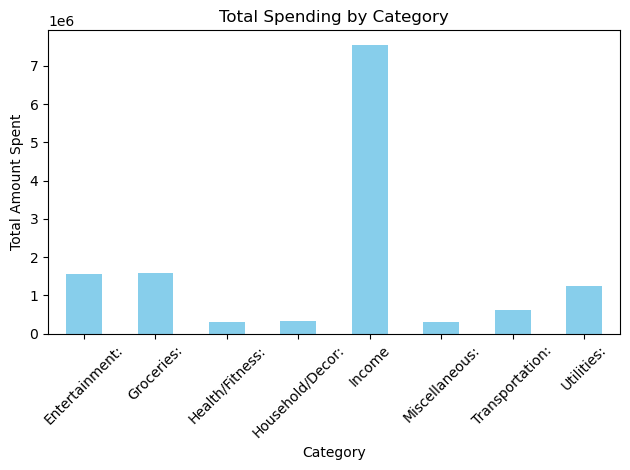

In [13]:
import matplotlib.pyplot as plt

# Plot the total spending per category
category_totals.plot(kind='bar', title='Total Spending by Category', color='skyblue')
plt.ylabel('Total Amount Spent')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
jupyter nbconvert --to script your_notebook.ipynb

SyntaxError: invalid syntax (2621717190.py, line 1)